In [10]:
# -*- coding: utf-8 -*-
%matplotlib inline
%load_ext autoreload
%autoreload 2

# add path of import
import sys
my_path = r'C:\Users\utente\Documents\GitHub\Project1_ML'
sys.path.insert(0,my_path + r'\code\COMMON')

# import
import numpy as np
import random
import matplotlib.pyplot as plt
from cross_validation import *

# import external modules
import numpy as np
import matplotlib.pyplot as plt

# import internal modules
from proj1_helpers import *
from implementations import *
from standard import standardize
from outliers import handle_outliers
from costs import *
from build_poly import *
from optimize_hyperparams import *
from labels import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Process Data

In [11]:
yb, input_data, ids = load_csv_data(my_path + r'\data\train.csv', sub_sample=False)

print("Data loaded! Shape:", np.shape(input_data))
print("Means: ", np.mean(input_data, axis=0), "  \nshape of the mean:", np.shape(np.mean(input_data, axis=0)), "\n")

#Outliers management
X, Y = handle_outliers(input_data, yb, -999, 'median')
print("New shape:",np.shape(X))
print("\nMeans: ", np.mean(X, axis=0))

#Replacing labels
ind_back, ind_sig = idx_2labels(Y, [-1,1])
Y[ind_back] = 0

Data loaded! Shape: (250000, 30)
Means:  [ -4.90230794e+01   4.92398193e+01   8.11819816e+01   5.78959617e+01
  -7.08420675e+02  -6.01237051e+02  -7.09356603e+02   2.37309984e+00
   1.89173324e+01   1.58432217e+02   1.43760943e+00  -1.28304708e-01
  -7.08985189e+02   3.87074191e+01  -1.09730480e-02  -8.17107200e-03
   4.66602072e+01  -1.95074680e-02   4.35429640e-02   4.17172345e+01
  -1.01191920e-02   2.09797178e+02   9.79176000e-01  -3.48329567e+02
  -3.99254314e+02  -3.99259788e+02  -6.92381204e+02  -7.09121609e+02
  -7.09118631e+02   7.30645914e+01]   
shape of the mean: (30,) 

-999 are replaced by the median value of the feature
New shape: (250000, 30)

Means:  [  1.20543057e+02   4.92398193e+01   8.11819816e+01   5.78959617e+01
   2.22114240e+00   2.72824209e+02  -4.40022052e-01   2.37309984e+00
   1.89173324e+01   1.58432217e+02   1.43760943e+00  -1.28304708e-01
   4.65892200e-01   3.87074191e+01  -1.09730480e-02  -8.17107200e-03
   4.66602072e+01  -1.95074680e-02   4.35429640e

In [12]:
#Standardization
X, mean_X, std_X = standardize(X)    
print("\nData standardized")
print("Means: ", np.mean(X, axis=0))


Data standardized
Means:  [ -1.06854250e-12   4.50019089e-15  -3.48448848e-15   7.19675786e-15
   7.31749967e-12   3.86173645e-12  -1.20614023e-13   2.16429719e-14
   6.39742126e-15   2.86409207e-15  -7.00447966e-15   4.45924897e-15
   6.09802649e-12  -5.96492045e-15   1.35646161e-16   7.13136217e-17
   2.58030370e-14  -1.06327391e-16  -1.87188487e-16   8.24369382e-15
   1.41040513e-16  -9.00283004e-15  -6.01698247e-16  -9.53515743e-13
   1.46076658e-15   2.47502161e-14   1.02151965e-11   1.97510182e-15
   2.54811581e-14  -8.76751116e-16]


# Adding Features

In [13]:
#Adding pure random feature column

def add_random_feature(X):
    
    randoms = np.array([random.gauss(0,1) for i in range(np.shape(X)[0])], ndmin=2).T
    X_ = np.concatenate((X, randoms), axis=1);
    
    return X_

print(np.shape(X))
X_f = add_random_feature(X)
print(np.shape(X_f))


(250000, 30)
(250000, 31)


# From now on the sample matrix is called X_f

# Removing Useless Features

tested lambda_:  [  1.00000000e-10   3.79269019e-10   1.43844989e-09   5.45559478e-09
   2.06913808e-08   7.84759970e-08   2.97635144e-07   1.12883789e-06
   4.28133240e-06   1.62377674e-05   6.15848211e-05   2.33572147e-04
   8.85866790e-04   3.35981829e-03   1.27427499e-02   4.83293024e-02
   1.83298071e-01   6.95192796e-01   2.63665090e+00   1.00000000e+01] 

------------------------------------------ cross validation with lambda_ =  1e-10
0.672
0.66972
0.67148
0.6706
0.66688
0.67336
0.67064
0.66976
0.67844
0.67432
------------------------------------------ cross validation with lambda_ =  3.79269019073e-10
0.672
0.66972
0.67148
0.6706
0.66688
0.67336
0.67064
0.66976
0.67844
0.67432
------------------------------------------ cross validation with lambda_ =  1.43844988829e-09
0.672
0.66972
0.67148
0.6706
0.66688
0.67336
0.67064
0.66976
0.67844
0.67432
------------------------------------------ cross validation with lambda_ =  5.45559478117e-09
0.672
0.66972
0.67148
0.6706
0.66688
0.6

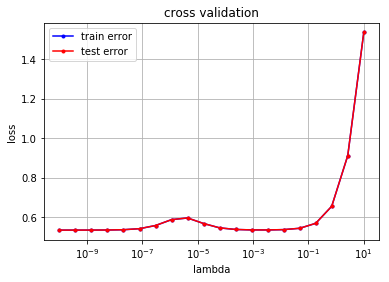

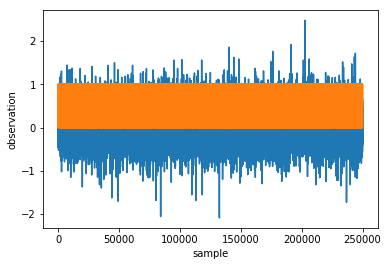

THE SUCCESS RATE IS: 0.671696


In [17]:
#Testing the noise feat against the others

# ridge regression parameters
arg_rr = dict()
arg_rr['method'] = 'rr'
arg_rr['loss'] = 'rmse'
arg_rr['k_fold'] = 10

# build polynomial basis with the optimal degree
phi_opt = build_poly(X_f, 3)

# optimization parameters
lambda_min = -10
lambda_max =1
lambda_steps = 20

# optimize lambda_
w_opt, loss_tr, loss_te, lambda_opt, success_rate = optimize_lambda(Y, X_f, lambda_min, lambda_max, lambda_steps, arg_rr, debug_mode=1)

# plot results
plt.figure()
plt.plot(X_f.dot(w_opt))
plt.plot(Y)
plt.xlabel('sample')
plt.ylabel('observation')
plt.show()

print("THE SUCCESS RATE IS:" , success_rate)

In [ ]:
X_f_new = build_poly(X_f, deg)

print(np.shape(X_f_new))

indexes = []

for i in range(1,np.shape(w_opt)[0],1):
    
    print("\nw_opt [", i, "] = ",  np.abs(w_opt[i]), "and w_opt[np.shape(w_opt)[0] - deg + (i-1)%deg] = ", np.abs(w_opt[np.shape(w_opt)[0] - deg + (i-1)%deg]))
    
    if np.abs(w_opt[i]) < np.abs(w_opt[np.shape(w_opt)[0] - deg + (i-1)%deg]):
        print("AAAAAA")
        indexes.append(i)
        
X_f_new = np.delete(X_f_new, indexes, axis=1)
        
print(np.shape(X_f_new))

#X_f_new = np.delete(X_f_new, 40, axis=1)
#print(np.shape(X_f_new))
